In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [ ]:
qubits = 8  # the number of qubits on which the unitaries act
n_shots = 100  # the number of times we can use each unitary

In [ ]:
import pennylane as qml
from pennylane.templates.layers import RandomLayers
from pennylane import numpy as np

np.random.seed(234087)

layers, gates = 10, 10  # the number of layers and gates used in RandomLayers


def generate_circuit(shots):
    """
    generate a random circuit that returns a number of measuement samples
    given by shots
    """
    dev = qml.device("lightning.qubit", wires=qubits, shots=shots)

    @qml.qnode(dev)
    def circuit(ts=False):

        if ts == True:
            ops = [qml.RY]  # time-symmetric unitaries
        else:
            ops = [qml.RX, qml.RY, qml.RZ]  # general unitaries

        weights = np.random.rand(layers, gates) * np.pi
        RandomLayers(weights, wires=range(qubits), rotations=ops, seed=np.random.randint(0, 10000))

        return [qml.sample(op=qml.PauliY(q)) for q in range(qubits)]

    return circuit

In [ ]:
# the measurement outcomes for the first 3 shots
circuit = generate_circuit(n_shots)
print(np.array(circuit(ts=True))[:, 0:3])
print("\n")
print(np.array(circuit(ts=False))[:, 0:3])

[[ 1.  1.  1.]
 [-1.  1.  1.]
 [ 1.  1. -1.]
 [-1.  1.  1.]
 [-1. -1. -1.]
 [ 1.  1. -1.]
 [ 1. -1.  1.]
 [ 1.  1.  1.]]


[[ 1. -1.  1.]
 [-1. -1.  1.]
 [ 1.  1. -1.]
 [ 1.  1.  1.]
 [ 1.  1. -1.]
 [ 1.  1. -1.]
 [-1.  1.  1.]
 [-1.  1.  1.]]


In [ ]:
circuits = 30  # the number of circuits in each data set

raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        circuit = generate_circuit(n_shots)
        raw_data.append(circuit(ts=ts))

In [ ]:
def process_data(raw_data):
    "convert raw data to vectors of means and variances of each qubit"

    raw_data = np.array(raw_data)
    nc = len(raw_data)  # the number of circuits used to generate the data
    nq = len(raw_data[0])  # the number of qubits in each circuit
    new_data = np.zeros([nc, 2 * nq])

    for k, outcomes in enumerate(raw_data):
        means = [np.mean(outcomes[q, :]) for q in range(nq)]
        variances = [np.var(outcomes[q, :]) for q in range(nq)]
        new_data[k] = np.array(means + variances)

    return new_data


data = process_data(raw_data)

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn import preprocessing

kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)

# rescale the data so it has unit standard deviation and zero mean.
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
# try to cluster the data
fit = kernel_pca.fit(data).transform(data)

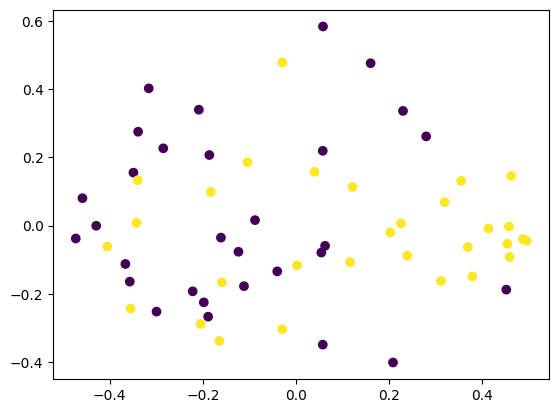

In [ ]:
import matplotlib.pyplot as plt

# make a colour map for the points
c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])

plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

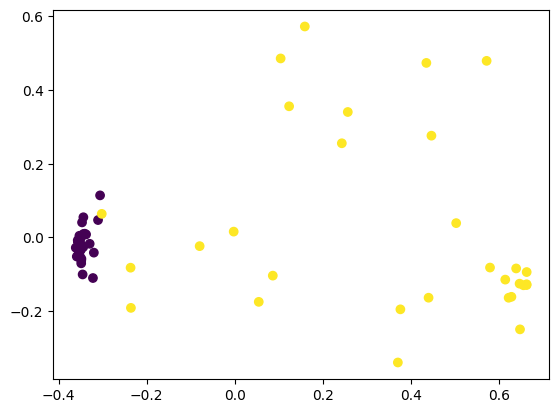

In [ ]:
n_shots = 10000  # 100 x more shots

raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        circuit = generate_circuit(n_shots)
        raw_data.append(circuit(ts=ts))

data = process_data(raw_data)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

fit = kernel_pca.fit(data).transform(data)

plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

In [ ]:
n_shots = 50
qubits = 8

dev = qml.device("lightning.qubit", wires=qubits * 2, shots=n_shots)


@qml.qnode(dev)
def enhanced_circuit(ts=False):
    "implement the enhanced circuit, using a random unitary"

    if ts == True:
        ops = [qml.RY]
    else:
        ops = [qml.RX, qml.RY, qml.RZ]

    weights = np.random.rand(layers, n_shots) * np.pi
    seed = np.random.randint(0, 10000)

    for q in range(qubits):
        qml.Hadamard(wires=q)

    qml.broadcast(
        qml.CNOT, pattern=[[q, qubits + q] for q in range(qubits)], wires=range(qubits * 2)
    )
    RandomLayers(weights, wires=range(0, qubits), rotations=ops, seed=seed)
    RandomLayers(weights, wires=range(qubits, 2 * qubits), rotations=ops, seed=seed)
    qml.broadcast(
        qml.CNOT, pattern=[[q, qubits + q] for q in range(qubits)], wires=range(qubits * 2)
    )

    for q in range(qubits):
        qml.Hadamard(wires=q)

    return [qml.sample(op=qml.PauliZ(q)) for q in range(2 * qubits)]

In [ ]:
raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        raw_data.append(enhanced_circuit(ts))

data = process_data(raw_data)

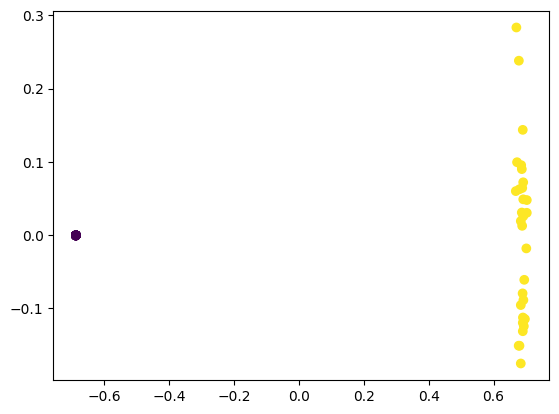

In [ ]:
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)

scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

fit = kernel_pca.fit(data).transform(data)

c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])
plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

In [ ]:
np.array(raw_data[0])[:, 0:5]  # outcomes of first 5 shots of the first T-symmetric circuit

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)

In [ ]:
def noise_layer(epsilon):
    "apply a random rotation to each qubit"
    for q in range(2 * qubits):
        angles = (2 * np.random.rand(3) - 1) * epsilon
        qml.Rot(angles[0], angles[1], angles[2], wires=q)

In [ ]:
@qml.qnode(dev)
def enhanced_circuit(ts=False):
    "implement the enhanced circuit, using a random unitary with a noise layer"

    if ts == True:
        ops = [qml.RY]
    else:
        ops = [qml.RX, qml.RY, qml.RZ]

    weights = np.random.rand(layers, n_shots) * np.pi
    seed = np.random.randint(0, 10000)

    for q in range(qubits):
        qml.Hadamard(wires=q)

    qml.broadcast(
        qml.CNOT, pattern=[[q, qubits + q] for q in range(qubits)], wires=range(qubits * 2)
    )
    RandomLayers(weights, wires=range(0, qubits), rotations=ops, seed=seed)
    RandomLayers(weights, wires=range(qubits, 2 * qubits), rotations=ops, seed=seed)
    noise_layer(np.pi / 4)  # added noise layer
    qml.broadcast(
        qml.CNOT, pattern=[[qubits + q, q] for q in range(qubits)], wires=range(qubits * 2)
    )

    for q in range(qubits):
        qml.Hadamard(wires=qubits + q)

    return [qml.sample(op=qml.PauliZ(q)) for q in range(2 * qubits)]

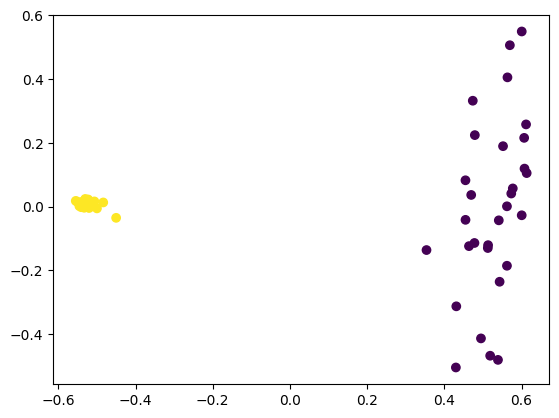

In [ ]:
raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        raw_data.append(enhanced_circuit(ts))

data = process_data(raw_data)

kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
fit = kernel_pca.fit(data).transform(data)

c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])
plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()